Fig. 5: Benchmark FateID
----

In this notebook, we extract FateID's fate biases and smoothed expression.

# Preliminaries

## Import packages

In [1]:
# import standard packages
import numpy as np
from rpy2.robjects import ListVector

import os
import sys

# import single-cell packages
import cellrank as cr
import anndata2ri

# set verbosity levels
cr.settings.verbosity = 2

anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(RaceID)
library(FateID)
library(destiny)

R[write to console]: 
Attaching package: ‘FateID’


R[write to console]: The following objects are masked from ‘package:RaceID’:

    diffexpnb, plotdiffgenesnb




## Print package versions for reproducibility

If you want to exactly reproduce the results shown here, please make sure that your package versions match what is printed below. 

In [3]:
cr.logging.print_versions()

cellrank==1.0.0-rc.12 scanpy==1.6.0 anndata==0.7.4 numpy==1.19.2 numba==0.51.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 scvelo==0.2.2 pygam==0.8.0 matplotlib==3.3.2 seaborn==0.11.0


In [4]:
%%R
print(packageVersion("RaceID"))
print(packageVersion("FateID"))

[1] ‘0.2.2’
[1] ‘0.1.9’


## Set up paths

Define the paths to load data, cache results and write figure panels.

In [5]:
sys.path.insert(0, "../../../../")  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, CACHE_DIR, FIG_DIR

## Set global parameters

In [6]:
root = str(DATA_DIR / "benchmarking" / "fateid")

## Define utility functions

In [7]:
%%R
# copy of plotexpressionProfile which extracts the LOESSed expression
extractData <- function (x, y, g, n, logsc = FALSE, col = NULL, name = NULL, cluster = FALSE, alpha = 0.5, lwd = 1, ylim = NULL){
    
    if ( logsc ){
        if ( min(x) == 0 ) x <- x + .1
        x <- x/apply(x,1,sum)
        x <- log2(x)
    }else{
        x <- x/apply(x,1,sum)
    }
    
    cl <- unique(y[n])
    set.seed(111111)
    if (is.null(col)) col <- sample(rainbow(length(n)))
    xlim <- c(1, length(n))
    z  <- x[g, n]
    zc <- z
    u <- 1:length(n)
       
    for ( i in 1:nrow(z) ){
        v <- as.vector(t(z[i,]))
        k <- predict(loess(v ~ u, span = alpha))
        if ( ! logsc ) k[k < 0] <- 0
        zc[i,] <- k
    }
    
    return(zc)
}

dptTraj <- function(x,y,fb,root_idxs,trthr=NULL,distance="euclidean",sigma=1000,...){
  trc <- list()
  pts <- list()  
  for ( j in colnames(fb$probs) ){
    if ( ! is.null(trthr) ){
      probs <- fb$probs
      n  <- rownames(probs)[probs[,j] > trthr]
    }else{
      votes <- fb$votes
      b <- bias(votes)
      n  <- rownames(votes)[b$bias[,j] > 1 & b$pv < .05]
    }
    dm <- destiny::DiffusionMap(as.matrix(t(x[,n])),distance=distance,sigma=sigma,...)
    root_idx <- root_idxs[[j]]
    pt <- destiny::DPT(dm, root_idx)
    pto <- pt[root_idx, ]
    
    #b <- pt@branch[, 1]
    #tip_idx <- which(b==1 & !is.na(b) & pt@tips[, 1])
    #pto <- pt[tip_idx, ]
    
    od <- order(pto,decreasing=FALSE)
    n <- n[od]

    #ts <- Transitions(as.matrix(t(x[,n])),distance=distance,sigma=sigma,...)
    #pt <- dpt::dpt(ts, branching = FALSE)
    #n <- n[order(pt$DPT,decreasing=FALSE)]
  
    if ( median((1:length(n))[y[n] == sub("t","",j)]) < median((1:length(n))[y[n] != sub("t","",j)]) ) {
        n <- rev(n)
        od <- rev(od)
    }
    trc[[j]] <- n
    pts[[j]] <- pto[od]
  }
  return(list(trc=trc,pts=pts))
}

# reason:
# Error in bias(votes) : could not find function "bias"
bias <- function(tvn){
  bias <- tvn/apply(tvn,1,function(x) x[order(x,decreasing=TRUE)][2] + 1e-3)
  pv <- apply(tvn,1,function(x){ h <- x[order(x,decreasing=TRUE)][1];  l <- x[order(x,decreasing=TRUE)][2]; binom.test( c(h, l), alternative="t" )$p.value})
  return(list(bias=bias,pv=pv))
}

## Load the data

Load the AnnData object from the CellRank software package. 

In [8]:
adata = cr.datasets.pancreas(DATA_DIR / "pancreas" / "pancreas.h5ad")
del adata.uns["neighbors"]  # creshed anndata2ri, we don't need it
adata

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# Analysis

## Convert AnnData to SCseq

In [9]:
%%R -i adata -i root
out_dir = root
X <- adata@assays@data[['X']]  # X, spliced, unspliced
rownames(X) <- rownames(adata)
colnames(X) <- colnames(adata)
# The raw expression data matrix with cells as columns and genes as rows in sparse matrix format.
sc <- SCseq(X)

## Filter, cluster and compute the embedding

In [10]:
%%R
sc <- filterdata(sc, mintotal=10)
sc <- compdist(sc, metric="logpearson")
sc <- clustexp(sc, samp=1000)
sc <- findoutliers(sc)
sc <- comptsne(sc)

Clustering k = 1,2,..., K.max (= 30): .. 
k = 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30 
done.
subset 1 
subset 2 
subset 3 
subset 4 
subset 5 
subset 6 
subset 7 
subset 8 
subset 9 
subset 10 
subset 11 
subset 12 
subset 13 
subset 14 
subset 15 
subset 16 
subset 17 
subset 18 
subset 19 
subset 20 
subset 21 
subset 22 
subset 23 
subset 24 
subset 25 
subset 26 
subset 27 
subset 28 
subset 29 
subset 30 
subset 31 
subset 32 
subset 33 
subset 34 
subset 35 
subset 36 
subset 37 
subset 38 
subset 39 
subset 40 
subset 41 
subset 42 
subset 43 
subset 44 
subset 45 
subset 46 
subset 47 
subset 48 
subset 49 
subset 50 
find outliers in cluster 1  2  3  4  5  6  7  8  9  10  11 
merging outliers 1  2  3  4  5  6  7  8  9  10  11 
determine final clustering partition 1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22 


## Extract data needed for fateBias

In [11]:
%%R
x <- as.matrix(getfdata(sc)[sc@cluster$features,])
print(dim(x))
genes <- c("Pax4", "Pdx1", "Arx", "Peg10", "Irs4" ,"Ghrl", "Hhex", "Cd24a")
for (gene in genes) {
    if (!gene %in% rownames(x)) {
        print(gene)
        rnames <- rownames(x)
        x <- rbind(x, getfdata(sc)[gene,])
        rownames(x) <- c(rnames, gene)
    }
}
for (gene in genes) {
    if (!gene %in% rownames(x)) {
        print(gene)
    }
}
print(dim(x))

markers <- list(Beta=c("Ins1"), Alpha=c("Gcg"), Epsilon=c("Ghrl"), Delta=c("Sst"))

# cell type partition based, n - positive integer number. For each component of FMarker the expression
# of all genes is aggregated in every cell and the n top-expressing cells are extracted.
pa <- getPart(x, markers, n=50)

# A vector with a partitioning, i. e. cluster assignment for each cell
clustering <- pa$part
# A vector with the numbers of target (end point) clusters.
# Cluster 1 comprises all cells with no enrichment of marker genes
endpoints <- pa$tar
z <- sc@distances

[1]  526 2531
[1] "Irs4"
[1]  527 2531


## Run fateBias

In [12]:
%%R
# fateBias(x, y, tar, z=NULL, minnr=5, minnrh=10, adapt=TRUE, confidence=0.75, nbfactor=5, use.dist=FALSE, seed=12345, nbtree=NULL)
# minr - step size of the algo (test size - number of cells to be classified per end point, recommended 5)
# minnrh - cells used for training (can be inf to use all previous cells, recommended: 20)
# x - data representation (e.g. could be only HVGs, PCA, ...)

# as.matrix(x) necessary if use.dist=FALSE
fb  <- fateBias(as.matrix(x), clustering, endpoints, z=z, minnr=5, minnrh=20, seed=123, use.dist=FALSE)

minnr: 5 
minnrh: 20 
test set size iteration 1 : 5 5 5 5 
randomforest iteration 1 of 20 cells
test set size iteration 2 : 5 3 3 2 
randomforest iteration 2 of 13 cells
test set size iteration 3 : 5 2.5 3.75 3.75 
randomforest iteration 3 of 15 cells
test set size iteration 4 : 5 2.5 1.666667 3.333333 
randomforest iteration 4 of 12 cells
test set size iteration 5 : 5 1.666667 0.8333333 1.666667 
randomforest iteration 5 of 10 cells
test set size iteration 6 : 5 1 1 2 
randomforest iteration 6 of 9 cells
test set size iteration 7 : 5 2.5 2.5 2.5 
randomforest iteration 7 of 11 cells
test set size iteration 8 : 5 2 1 3 
randomforest iteration 8 of 11 cells
test set size iteration 9 : 3.333333 3.333333 3.333333 5 
randomforest iteration 9 of 14 cells
test set size iteration 10 : 5 3.333333 3.333333 5 
randomforest iteration 10 of 16 cells
test set size iteration 11 : 5 1 4 3 
randomforest iteration 11 of 13 cells
test set size iteration 12 : 5 2.5 5 5 
randomforest iteration 12 of 17 ce

randomforest iteration 103 of 7 cells
test set size iteration 104 : 5 5 5 5 
randomforest iteration 104 of 16 cells
test set size iteration 105 : 1.25 1.25 2.5 5 
randomforest iteration 105 of 9 cells
test set size iteration 106 : 1.666667 1.666667 3.333333 5 
randomforest iteration 106 of 11 cells
test set size iteration 107 : 1 1 3 5 
randomforest iteration 107 of 9 cells
test set size iteration 108 : 1.25 1.25 2.5 5 
randomforest iteration 108 of 7 cells
test set size iteration 109 : 2.5 2.5 2.5 5 
randomforest iteration 109 of 8 cells
test set size iteration 110 : 5 5 5 5 
randomforest iteration 110 of 15 cells
test set size iteration 111 : 2.5 2.5 5 5 
randomforest iteration 111 of 12 cells
test set size iteration 112 : 1.25 1.25 5 2.5 
randomforest iteration 112 of 8 cells
test set size iteration 113 : 1.666667 1.666667 3.333333 5 
randomforest iteration 113 of 12 cells
test set size iteration 114 : 2.5 2.5 2.5 5 
randomforest iteration 114 of 10 cells
test set size iteration 115

### Extract the values

In [13]:
%%R -o res
trthr = 0.15  # fate bias threshold
res = list()
for ( j in colnames(fb$probs) ){
  probs <- fb$probs
  n  <- rownames(probs)[probs[,j] > trthr]
  res[[j]] = n
}

### Identify root cells witin each lineage

In [14]:
adata_preprocessed = cr.datasets.pancreas_preprocessed(DATA_DIR / "pancreas" / "pancreas_preprocessed.h5ad")
root_names = []

for i in range(2, 6):
    indices = res.rx2(f"t{i}")
    tmp = adata_preprocessed[indices].obs['dpt_pseudotime']
    ix = tmp.argmin()
    root_names.append(tmp.index[ix])
    
print(root_names)

root_ixs = []
for root_name, key in zip(root_names, [f"t{i}" for i in range(2, 6)]):
    # +1 because R indexes from 1
    root_ixs.append(np.where(res.rx2(key) == root_name)[0][0] + 1)
root_ixs = dict(zip([f"t{i}" for i in range(2, 6)], root_ixs))
print(root_ixs)
root_ixs = ListVector(root_ixs)

['CATCGGGTCTTCGGTC-1-3', 'ACATACGGTCCCGACA-1-3', 'AAACGGGTCAGCTCTC-1-3', 'TCTGAGATCTGAGTGT-1-3']
{'t2': 143, 't3': 69, 't4': 7, 't5': 1701}


## Run DPT

In [15]:
%%R -i root_ixs
trc <- dptTraj(as.matrix(x), clustering, fb, root_ixs, trthr=trthr, distance="euclidean")
pts <- trc[['pts']]
trc <- trc[['trc']]
names(trc) <- c('Beta', 'Alpha', 'Epsilon', 'Delta')
names(pts) <- c('Beta', 'Alpha', 'Epsilon', 'Delta')

## Extract and save the data for plotting

### Save the fate biases, smoothed expression values and DPT

In [17]:
%%R
for (lineage in names(trc)) {
    n <- trc[[lineage]]
    fs <- filterset(x,n=n, minexpr=0)
    for (gene in genes) {
        stopifnot(gene %in% rownames(fs))
    }
    # this is the same as plotexpressionProfile, but we return the LOESS'd data
    tmp <- extractData(as.matrix(x), clustering, g=genes, n=n, cluster=FALSE, logsc=FALSE)
    
    write.csv(t(tmp), paste0(out_dir, "/", lineage, ".csv"))
    write.csv(pts[[lineage]], paste0(out_dir, "/", lineage, "_pt.csv"))
    write.csv(trc[[lineage]], paste0(out_dir, "/", lineage, "_ixs.csv"))
}

write.csv(fb$probs, paste0(out_dir, "/", "probs.csv"))

## Visualize smoothed trends for the Delta lineage

[1] "Delta"


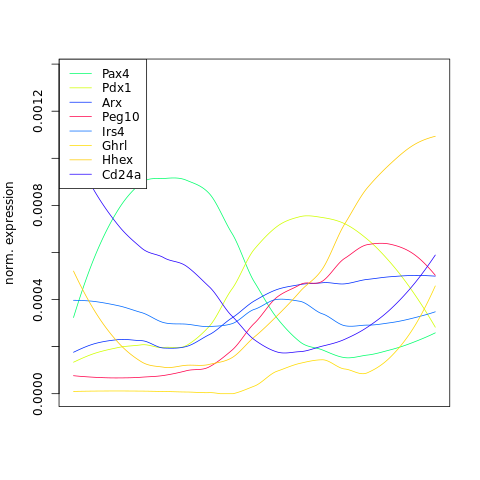

In [18]:
%%R
print(lineage)
for (gene in genes) {
    stopifnot(gene %in% rownames(x))
}
plotexpressionProfile(x, clustering, n=n, g=genes, cluster=FALSE, logsc=FALSE)